In [5]:
import sys
import os
os.environ["SUMO_HOME"] = "../sumo/"
sys.path.append(
os.path.join(os.environ["SUMO_HOME"], "tools")
)
import traci
import traci.constants as tc
import time
from collections import Counter
import xml.etree.ElementTree as ET
import numpy as np
import math
import matplotlib.pyplot as plt



In [6]:
# vertical lanes start with edge 4 and edge 3
area_length = 600
grid_width = 4
listLanes=['edge1-0_0','edge1-0_1','edge1-0_2','edge2-0_0','edge2-0_1','edge2-0_2',
           'edge3-0_0','edge3-0_1','edge3-0_2','edge4-0_0','edge4-0_1','edge4-0_2']

# assgin sumo code to each phase
phases = {
    "WGREEN": "grrr gGGG grrr gGGG".replace(" ", ""),
    "NGREEN": "gGGG grrr gGGG grrr".replace(" ", "") 
    }
def get_id_phase(phase):
    if phase == phases["WGREEN"]:
        return "WGREEN"
    if phase == phases["NGREEN"]:
        return "NGREEN"

In [101]:
""" Functions to interact with sumo """


class Vehicles:
    initial_speed = 5.0

    def __init__(self):
        # add what ever you need to maintain
        self.id = None
        self.speed = None
        self.wait_time = None
        self.stop_count = None
        self.enter_time = None
        self.has_read = False
        self.first_stop_time = -1
        self.entering = True
        
    
def set_traffic_file(sumo_config_file_tmp_name, sumo_config_file_output_name, list_traffic_file_name):
        """ Set the traffic file in the sumo config"""
        # update sumocfg
        sumo_cfg = ET.parse(sumo_config_file_tmp_name)
        config_node = sumo_cfg.getroot()
        input_node = config_node.find("input")
        for route_files in input_node.findall("route-files"):
            input_node.remove(route_files)
        input_node.append(
            ET.Element("route-files", attrib={"value": ",".join(list_traffic_file_name)}))
        sumo_cfg.write(sumo_config_file_output_name)

def start_sumo(traffic):
    """ Start sumo, 3 config possibles"""
    trafic_files = {"alternate": "cross.2phases_rou1_switch_rou0.xml",
                    "equal": "cross.2phases_rou01_equal_300s.xml",
                    "unequal": "cross.2phases_rou01_unequal_5_300s.xml"
                   }
    file = trafic_files[traffic]
    set_traffic_file(
        os.path.join('data/one_run', "cross.sumocfg"),
        os.path.join('data/one_run', "cross.sumocfg"),
        [file])
    sumoCmd = ['/usr/local/bin/sumo', '-c', '/Users/danieltordjman/Documents/MVA/TraficLight/IntelliLight/data/one_run/cross.sumocfg',]
    traci.start(sumoCmd)
    for i in range(20):
        traci.simulationStep()

        
def get_state_sumo():
    """ Put here what we need to define the state. For now only the number of vehicles by lines"""
    vehicle_roads = Counter()

    vehicle_id_list = traci.vehicle.getIDList()
    for vehicle_id in vehicle_id_list:
        road_id = traci.vehicle.getRoadID(vehicle_id)
        vehicle_roads[road_id] += 1
    return vehicle_roads

def is_blocked(lane, phase):
    """ return True if the line is blocked"""
    if "edge3" in lane and phase == "WGREEN":
        return True
    if "edge4" in lane and phase == "WGREEN":
        return True
    if "edge1" in lane and phase == "NGREEN":
        return True
    if "edge2" in lane and phase == "NGREEN":
        return True
    return False

def get_overall_queue_length(listLanes, blocked_only=False):
    """ return queue length, overall or only the blockes lines """
    overall_queue_length = 0
    sumo_phase = traci.trafficlights.getRedYellowGreenState("node0")
    phase = get_id_phase(sumo_phase)
    for lane in listLanes:

        blocked = is_blocked(lane, phase)
        if not blocked_only or blocked:
            overall_queue_length += traci.lane.getLastStepHaltingNumber(lane)

    return overall_queue_length


def get_overall_waiting_time(listLanes):
    """ Unused for now"""
    overall_waiting_time = 0
    for lane in listLanes:
        overall_waiting_time += traci.lane.getWaitingTime(str(lane)) / 60.0
    return overall_waiting_time

def get_travel_time_duration(vehicle_dict, vehicle_id_list):
    """ Unused for now"""
    travel_time_duration = 0
    for vehicle_id in vehicle_id_list:
        if (vehicle_id in vehicle_dict.keys()):
            travel_time_duration += (traci.simulation.getCurrentTime() / 1000 - vehicle_dict[vehicle_id].enter_time)/60.0
    if len(vehicle_id_list) > 0:
        return travel_time_duration#/len(vehicle_id_list)
    else:
        return 0
    

def get_vehicle_id_entering():
    vehicle_id_entering = []
    entering_lanes = ['edge1-0_0', 'edge1-0_1', 'edge1-0_2', 'edge2-0_0', 'edge2-0_1', 'edge2-0_2',
                     'edge3-0_0', 'edge3-0_1', 'edge3-0_2', 'edge4-0_0', 'edge4-0_1', 'edge4-0_2']

    for lane in entering_lanes:
        vehicle_id_entering.extend(traci.lane.getLastStepVehicleIDs(lane))

    return vehicle_id_entering

def update_vehicles_state(dic_vehicles):
    """ Update a dictionnary with vehicles classed based on the current state of the simulation"""
    vehicle_id_list = traci.vehicle.getIDList()
    vehicle_id_entering_list = get_vehicle_id_entering()
    for vehicle_id in (set(dic_vehicles.keys())-set(vehicle_id_list)):
        del(dic_vehicles[vehicle_id])

    for vehicle_id in vehicle_id_list:
        if (vehicle_id in dic_vehicles.keys()) == False:
            vehicle = Vehicles()
            vehicle.id = vehicle_id
            traci.vehicle.subscribe(vehicle_id, (tc.VAR_LANE_ID, tc.VAR_SPEED))
            vehicle.speed = traci.vehicle.getSubscriptionResults(vehicle_id).get(64)
            current_sumo_time = traci.simulation.getCurrentTime()/1000
            vehicle.enter_time = current_sumo_time
            # if it enters and stops at the very first
            if (vehicle.speed < 0.1) and (vehicle.first_stop_time == -1):
                vehicle.first_stop_time = current_sumo_time
            dic_vehicles[vehicle_id] = vehicle
        else:
            dic_vehicles[vehicle_id].speed = traci.vehicle.getSubscriptionResults(vehicle_id).get(64)
            if (dic_vehicles[vehicle_id].speed < 0.1) and (dic_vehicles[vehicle_id].first_stop_time == -1):
                dic_vehicles[vehicle_id].first_stop_time = traci.simulation.getCurrentTime()/1000
            if (vehicle_id in vehicle_id_entering_list) == False:
                dic_vehicles[vehicle_id].entering = False

    return dic_vehicles



In [102]:
""" Function to plot state of the traffic as an image"""


def vehicle_location_mapper(coordinate, area_length=600, area_width=600):
    transformX = math.floor(coordinate[0] / grid_width)
    transformY = math.floor((area_length - coordinate[1]) / grid_width)
    length_num_grids = int(area_length/grid_width)
    transformY = length_num_grids-1 if transformY == length_num_grids else transformY
    transformX = length_num_grids-1 if transformX == length_num_grids else transformX
    tempTransformTuple = (transformY, transformX)
    return tempTransformTuple

def plotcurrenttrafic():
    """ Plot the curretn state of the traffic"""
    length_num_grids = int(area_length/grid_width)
    mapOfCars = np.zeros((length_num_grids, length_num_grids))

    vehicle_id_list = traci.vehicle.getIDList()
    for vehicle_id in vehicle_id_list:

        vehicle_position = traci.vehicle.getPosition(vehicle_id)  # (double,double),tuple

        transform_tuple = vehicle_location_mapper(vehicle_position)  # call the function
        mapOfCars[transform_tuple[0], transform_tuple[1]] = 1
    plt.imshow(mapOfCars)
    plt.show()

def plottraffic(N):
    """ Plot evolution of the traffic for N steps without changing the phase"""
    for i in range(N):
        length_num_grids = int(area_length / grid_width)
        for i in range(10):
            traci.simulationStep()
        plotcurrenttrafic()
        print(get_state_sumo())
        
        



In [106]:
""" Defintion environement and first definition of policy """

class sumoEnv():

    def __init__(self):
        self.vehicle_dict = {}
        self.update_state()
        self.n_states = 4 ** 4 * 2
        self.n_actions = 2
        
    def encode_state(self):
        "assign an integer between 1 and 511 to each state"
        phase = int(self.phase == "WGREEN")
        state = np.array([0,0,0,0])
        for line, num_vehicles in self.state_sumo.items():
            #integer for the axis
            try:
                i = int(line[4]) - 1
                if i < 0:
                    # line 0, à priori on doit pas la considérer
                    continue
            except:
                continue
            if num_vehicles < 3:
                state[i] = 0
            elif num_vehicles < 5:
                state[i] = 1
            elif num_vehicles < 7:
                state[i] = 2
            else:
                state[i] = 3
            
        s = 0
        s = phase + np.dot(state, np.array([2, 4*2, 4**2*2, 4**3*2]))
        return s
            
    def update_state(self):
  
        self.state_sumo = get_state_sumo()
 
        self.vehicle_dict = update_vehicles_state(self.vehicle_dict)
        phase = traci.trafficlights.getRedYellowGreenState("node0")
        if phase == phases["WGREEN"]:
            self.phase = "WGREEN"
        else:
            self.phase = "NGREEN"
        
    def get_reward(self, blocked_only=True):
        queue = get_overall_queue_length(listLanes, blocked_only=blocked_only)
        w_time = get_overall_waiting_time(listLanes)
        
        return - w_time
        
    def step(self, change=True):
        WGREEN = "grrr gGGG grrr gGGG".replace(" ", "")
        NGREEN = "gGGG grrr gGGG grrr".replace(" ", "")
        
        if change:
            if self.phase == "WGREEN":
                traci.trafficlights.setRedYellowGreenState("node0", phases['NGREEN'])
            else:
                traci.trafficlights.setRedYellowGreenState("node0", phases['WGREEN'])
                
        self.update_state()
        return self.encode_state(), self.get_reward()
        
        
    
    


 Retrying in 1 seconds


/Users/danieltordjman/Documents/MVA/TraficLight/IntelliLight/venv/lib/python3.6/site-packages/ipykernel_launcher.py:126: DeprecationWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds


 Retrying in 1 seconds


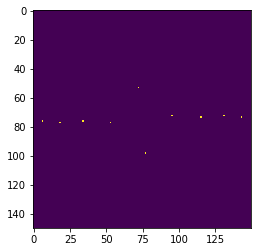

[0.0]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 495. 507.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.


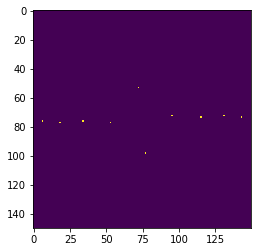

 Retrying in 1 seconds


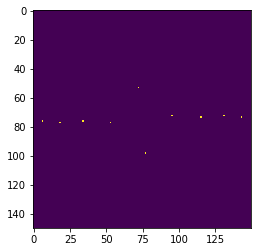

 Retrying in 1 seconds


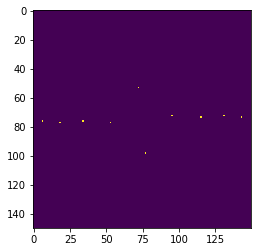

 Retrying in 1 seconds


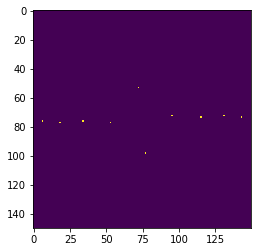

 Retrying in 1 seconds


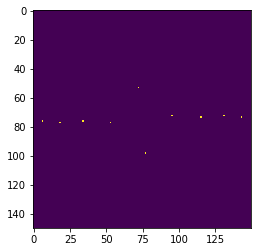

 Retrying in 1 seconds


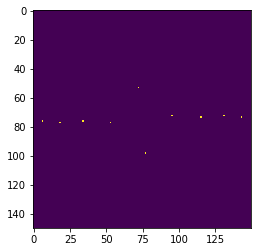

 Retrying in 1 seconds


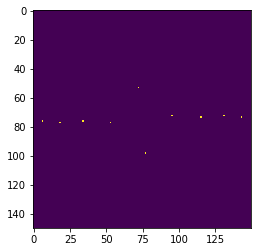

 Retrying in 1 seconds


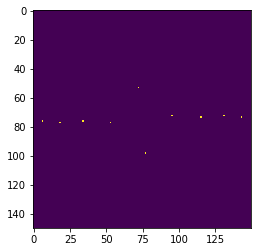

 Retrying in 1 seconds


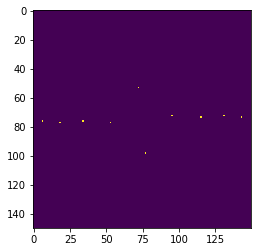

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [107]:
N_test = 200

def q_learning(n=N_test, epsilon=0.4, beta=0.55):
    start_sumo("unequal")
    env = sumoEnv()
    Q =  np.zeros((env.n_states, 2))
    T = np.zeros((env.n_states, 2))
    gamma = 0.7
    
    rewards = []
    visited_states = np.zeros(env.n_states)
    for i in range(n):
        t = 0
        start_sumo("unequal")
        env = sumoEnv()
        s = env.encode_state()
        visited_states[s] += 1

        reward = 0
        Tmax = 1000 # equivalent 2 hours ?
        while t <= Tmax:
            t += 1
            if np.random.uniform(0, 1) < epsilon:
                a = np.random.choice([0,1])
            else:
                a = np.argmax(Q[s])
            T[s,a] += 1.
            next_s, r = env.step(a)

            #time.sleep(1./fps)
            q = Q[s,a]
            q_next = np.max(Q[next_s])
            alpha = (1 / T[s,a]) ** beta
            q = (1 - alpha) * q + alpha * (r + gamma * q_next)
            Q[s,a] = q

            s = next_s
            visited_states[s] += 1
            reward += r * gamma ** (t - 1)

        plotcurrenttrafic()

        if i % 10 == 0:

           
            rewards += [reward]
         

    pi = np.argmax(Q, axis=1)
    return pi, rewards, visited_states

q_learning(10)


In [49]:
def simple_rule(length_max=10, N=5000):
    """ Try simple rule which change the lights based only on the queue lenght"""
    start_sumo("unequal")
    env = sumoEnv()
    r = env.take_action(change=False)
    rewards = []
    for i in range(N):
        change =  (r <= -length_max)

        if change:
            print(r, "Changing state")

        r = env.step(change=change)
        rewards += [r]
        if i % 199 == 0:
            plotcurrenttrafic()
        
    plt.plot(range(N), rewards)
    

    

AttributeError: 'sumoEnv' object has no attribute 'state'